In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.nn import init

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from matplotlib import colors

import wandb
wandb.init(project="vae-project")

%matplotlib inline

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


In [8]:
class Encoder(nn.Module):

    def __init__(self, units=500, z_dim=32):
        super(Encoder, self).__init__()
        
        self.dense = nn.Linear(28*28, units)
        self.mean = nn.Linear(units, z_dim)
        self.log_var = nn.Linear(units, z_dim)
        
    def forward(self, x):
        x = torch.tanh(self.dense(x))
        mean = self.mean(x)
        log_var = self.log_var(x)
        var = torch.exp(log_var)
        std = torch.sqrt(var)
        
        self.kl_loss = -(0.5 * torch.sum(1 + log_var - mean**2 - var))
        return mean, std

class GaussianDecoder(nn.Module):
    def __init__(self, z_dim=32, units=500):
        super(GaussianDecoder, self).__init__()
        self.dense = nn.Linear(z_dim, units)
        self.mean = nn.Linear(units, 28*28)
        self.log_var = nn.Linear(units, 28*28)
        
    def forward(self, z):
        z = torch.tanh(self.dense(z))
        mean = self.mean(z)
        log_var = self.log_var(z)
        var = torch.exp(log_var)
        std = torch.sqrt(var)
        return mean, std

class BenroulliDecoder(nn.Module):
    def __init__(self, z_dim=32, units=500):
        super(BenroulliDecoder, self).__init__()
        self.dense = nn.Linear(z_dim, units)
        self.out = nn.Linear(units, 28*28)
        
    def forward(self, z):
        z = torch.tanh(self.dense(z))
        out = torch.sigmoid(self.out(z))
        return out
    
class VAE(nn.Module):
    def __init__(self, latent_dim=32):
        super(VAE, self).__init__()
        self.encoder = Encoder(z_dim=latent_dim)
        self.decoder = GaussianDecoder(z_dim=latent_dim)
        
    def forward(self, x, num_samples=1):
        batch_size = x.shape[0]
        x = torch.flatten(x,1)
        z_params = self.encoder(x)
        z_samples = torch.distributions.Normal(*z_params).rsample((num_samples,))
        x_params = self.decoder(z_samples)
        reconstructed_x = torch.distributions.Normal(*x_params)
        self.reconstruction_loss = -((1/num_samples) * torch.sum(reconstructed_x.log_prob(x)))
        self.loss = self.encoder.kl_loss + self.reconstruction_loss
        reconstructed_x = torch.reshape(reconstructed_x.sample(), (num_samples, batch_size, 1, 28, 28))
        
        return reconstructed_x

# class VAE(nn.Module):
#     def __init__(self, latent_dim=32):
#         super(VAE, self).__init__()
#         self.encoder = Encoder(z_dim=latent_dim)
#         self.decoder = GaussianDecoder(z_dim=latent_dim)
        
#     def forward(self, x, num_samples=1):
#         batch_size = x.shape[0]
#         x = torch.flatten(x,1)
#         z = self.encoder(x)
#         samples = z.rsample((num_samples, ))
#         reconstructed_x = self.decoder(samples)
#         self.reconstruction_loss = -((1/num_samples) * torch.sum(F.))
#         self.loss = self.encoder.kl_loss + self.reconstruction_loss
#         reconstructed_x = torch.reshape(reconstructed_x.rsample(), (num_samples, batch_size, 28, 28))
#         return reconstructed_x
    
    
def train(model, device, train_loader, optimizer, epoch):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        prediction = model(data)
        loss = (1/128) * model.loss
        loss.backward()
        optimizer.step()

        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))

            wandb.log({"training loss": model.loss, 
                       "training kl loss": model.encoder.kl_loss / 128, 
                       "training reconstruction loss": model.reconstruction_loss / 128})

def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    kl_loss = 0
    reconstruction_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += ((1/10000) * model.loss).item()  # sum up batch loss
            kl_loss += ((1/10000) * model.encoder.kl_loss).item()
            reconstruction_loss += ((1/10000) * model.reconstruction_loss).item()
        
    wandb.log({"test loss": test_loss, 
           "test kl loss": kl_loss, 
           "test reconstruction loss": reconstruction_loss})
        
    if epoch % 10 == 0:
        z = torch.distributions.Normal(loc=torch.zeros((5, 32,)), scale=torch.ones((5, 32,)))
        z_params = model.decoder(z.sample().to(device))
        samples = torch.reshape(torch.distributions.Normal(*z_params).sample(), (5, 28, 28)).cpu().numpy()
        wandb.log({"examples" : [wandb.Image(i) for i in samples]})

    print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))

In [ ]:
device = torch.device('cuda:0')

batch_size = 128
epochs = 500

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_data = datasets.MNIST('./mnist/', transform=transform)
validation_data = datasets.MNIST('./mnist/', train=False,
                                 transform=transform)

train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8
)

test_loader = torch.utils.data.DataLoader(
    validation_data,
    batch_size=1000,
    shuffle=True,
    num_workers=8,
)

model = VAE().to(device)
optimizer = optim.Adagrad([
    {'params': model.encoder.parameters()},
    {'params': model.decoder.parameters(), 'weight_decay': 0.1}
], lr=0.001)
wandb.watch(model, log="all")

def weights_init(m):
    if isinstance(m, nn.Linear):
        init.normal_(m.weight, 0.0, 0.01)
        init.normal_(m.bias, 0.0, 0.01)

model.apply(weights_init)
        
for epoch in range(epochs):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader, epoch)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Train Epoch: 0 [0/60000 (0%)]	Loss: 1099.362671
Train Epoch: 0 [25600/60000 (43%)]	Loss: 141.965912
Train Epoch: 0 [51200/60000 (85%)]	Loss: 117.908699

Test set: Average loss: 83.0499

Train Epoch: 1 [0/60000 (0%)]	Loss: 103.185036
Train Epoch: 1 [25600/60000 (43%)]	Loss: 81.384750
Train Epoch: 1 [51200/60000 (85%)]	Loss: 66.534164

Test set: Average loss: 42.4827

Train Epoch: 2 [0/60000 (0%)]	Loss: 50.080872
Train Epoch: 2 [25600/60000 (43%)]	Loss: 227.022491
Train Epoch: 2 [51200/60000 (85%)]	Loss: 86.000450

Test set: Average loss: 10.6581

Train Epoch: 3 [0/60000 (0%)]	Loss: 19.416458
Train Epoch: 3 [25600/60000 (43%)]	Loss: 85.865837
Train Epoch: 3 [51200/60000 (85%)]	Loss: -70.420029

Test set: Average loss: 6.8080

Train Epoch: 4 [0/60000 (0%)]	Loss: -39.233215
Train Epoch: 4 [25600/60000 (43%)]	Loss: 26.948807
Train Epoch: 4 [51200/60000 (85%)]	Loss: -41.806549

Test set: Average loss: -25.5894

Train Epoch: 5 [0/60000 (0%)]	Loss: -88.165596
Train Epoch: 5 [25600/60000 (43%)]

In [ ]:
z = torch.distributions.Normal(loc=torch.zeros((32,)), scale=torch.ones((32,)))
(0.1307,), (0.3081,)

In [63]:
x = torch.reshape(model.decoder(z.sample().to(device)).sample(), (28,28)) * .3081 + 0.1307

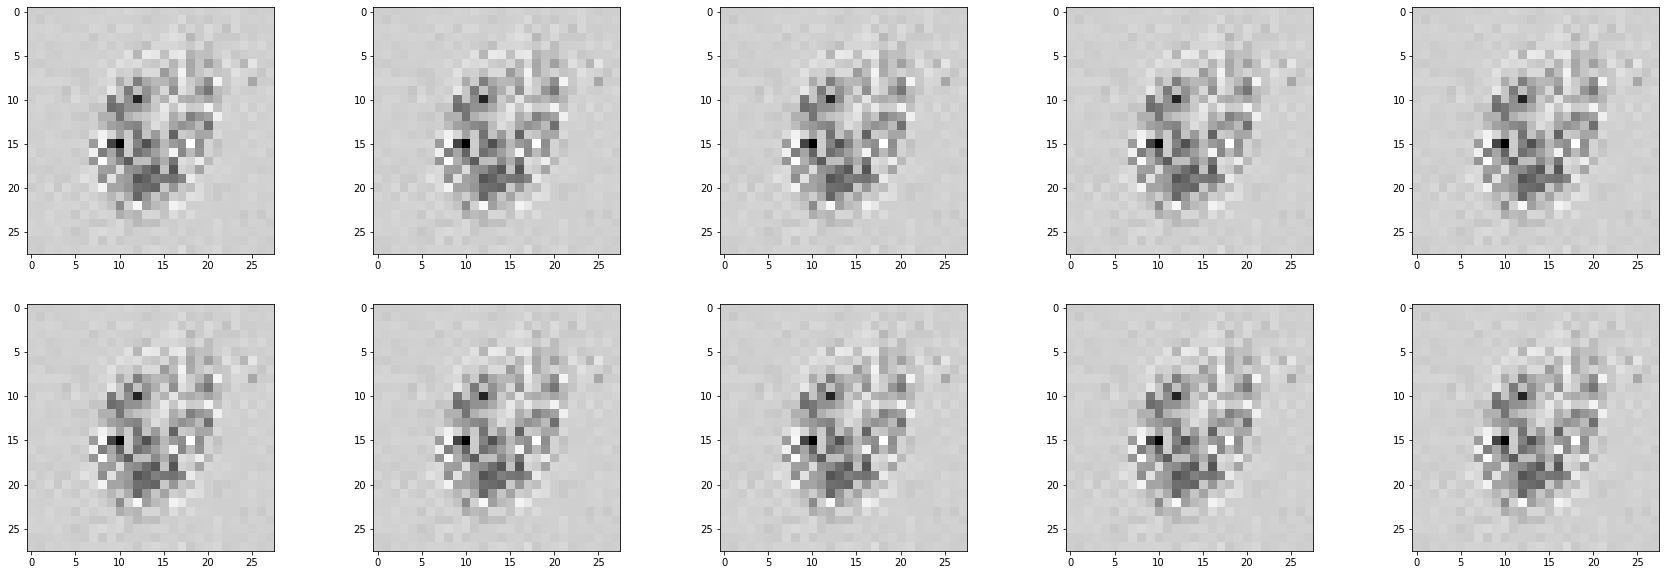

In [87]:
fig, axs = plt.subplots(2, 5, figsize=(30,10))
for row in axs:
    for ax in row:
        ax.imshow(x.cpu(), cmap='Greys', norm=colors.Normalize())

In [76]:
example = train_loader.__iter__().next()[0][0]
example

tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242,  0.6450,  2.8215,  2.1087,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242,  0.6704,  2.7706,  2.7451,  0.5431,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0

In [54]:
dir(train_loader)

['_DataLoader__initialized',
 '_DataLoader__multiprocessing_context',
 '_IterableDataset_len_called',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_auto_collation',
 '_dataset_kind',
 '_index_sampler',
 'batch_sampler',
 'batch_size',
 'collate_fn',
 'dataset',
 'drop_last',
 'multiprocessing_context',
 'num_workers',
 'pin_memory',
 'sampler',
 'timeout',
 'worker_init_fn']

In [35]:
for m in model.named_children():
    print(m)

('encoder', Encoder(
  (dense): Linear(in_features=784, out_features=500, bias=True)
  (mean): Linear(in_features=500, out_features=32, bias=True)
  (log_var): Linear(in_features=500, out_features=32, bias=True)
))
('decoder', GaussianDecoder(
  (dense): Linear(in_features=32, out_features=500, bias=True)
  (mean): Linear(in_features=500, out_features=784, bias=True)
  (log_var): Linear(in_features=500, out_features=784, bias=True)
))


In [44]:
model = VAE().to(device)

def weights_init(m):
    if isinstance(m, nn.Linear):
        init.normal_(m.weight, 0.0, 0.01)
        init.normal_(m.bias, 0.0, 0.01)

model.apply(weights_init)

for name, param in model.named_parameters():
    print(name)
    print(param.shape)
    print(param)

encoder.dense.weight
torch.Size([500, 784])
Parameter containing:
tensor([[-0.0064,  0.0120, -0.0143,  ..., -0.0038,  0.0143, -0.0100],
        [-0.0093, -0.0072, -0.0008,  ..., -0.0013, -0.0177, -0.0073],
        [ 0.0086, -0.0201, -0.0062,  ...,  0.0021,  0.0043,  0.0206],
        ...,
        [ 0.0036,  0.0036, -0.0075,  ...,  0.0051,  0.0180, -0.0051],
        [-0.0066, -0.0075, -0.0079,  ..., -0.0022,  0.0040,  0.0058],
        [ 0.0076, -0.0049, -0.0008,  ..., -0.0308, -0.0187, -0.0118]],
       device='cuda:0', requires_grad=True)
encoder.dense.bias
torch.Size([500])
Parameter containing:
tensor([-1.7255e-02,  1.2876e-03, -1.7940e-02, -5.5748e-03, -8.5161e-03,
         9.3608e-03, -3.8954e-03,  9.1603e-03, -7.9353e-04, -5.5534e-03,
        -5.0324e-03, -5.5355e-03,  9.8530e-03, -1.0357e-02, -1.2586e-02,
         1.6232e-02,  1.0596e-02, -1.1701e-02, -1.4952e-03, -1.0913e-02,
         3.9395e-03,  1.2993e-02, -3.6659e-03, -9.8283e-04, -1.2446e-02,
        -1.2244e-02,  2.4599e-03